In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ln -s /content/drive/MyDrive/src/XAI-CV-CounterfactualSamples .

In [ ]:
%cd XAI-CV-CounterfactualSamples

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples


In [ ]:
! ln -s /content/drive/MyDrive/datasets/HAM10000 datasets

ln: failed to create symbolic link 'datasets/HAM10000': File exists


In [ ]:
%cd exp_ham10k

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_ham10k


In [ ]:
! pip install tensorflow==2.15.1 > /content/install.log

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.1 which is incompatible.


# Initialization

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.1


In [ ]:
import importlib
import configs
importlib.reload(configs)

<module 'configs' from '/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_ham10k/configs.py'>

# Data Loader

In [ ]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, subsets_file, subset, batch_size=32, shuffle=False):
        self.data_dir = data_dir
        self.subsets_file = subsets_file
        self.subset = subset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.filenames = None
        self.classnames = None
        self.dict_class_names = None

        self.load_data()
        self.indices = None
        self.on_epoch_end()

    def load_data(self):
        df_files = pd.read_csv(self.subsets_file)
        self.df_files = df_files[df_files['subset'] == self.subset]
        self.filenames = self.df_files['filename'].tolist()
        self.classnames = self.df_files['classname'].tolist()
        self.dict_class_names = {name:i for i, name in enumerate(configs.CLASS_NAMES)}
        print('*** load_data')
        print(self.subset)
        print(len(self.filenames), 'found')
        print(df_files.head())
        print('***')

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        classnames = [self.classnames[k] for k in indices]
        X, Y = self.__data_generation(filenames, classnames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def toOneHot(self, classname):
        v = np.zeros(configs.NUM_CLASS, dtype=np.float64)
        v[self.dict_class_names[classname]] = 1.0
        return v

    def __data_generation(self, filenames, classnames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y = np.empty([num, configs.NUM_CLASS])
        HH, WW, _ = configs.IMAGE_SIZE
        for i, fn in enumerate(filenames):
            img = plt.imread(configs.DATA_DIR+'/'+fn)
            delta = (WW - HH) // 2
            img = img[:, delta:WW-delta-1]
            img = cv2.resize(img, configs.IMAGE_SIZE[:2])
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y[i] = self.toOneHot(classnames[i])

        return X, filenames

In [ ]:
train_datagen = MyDataGenerator(configs.DATA_DIR, configs.SUBSETS_FILE, 'train', shuffle=True)
val_datagen = MyDataGenerator(configs.DATA_DIR, configs.SUBSETS_FILE, 'val', shuffle=True)
test_datagen = MyDataGenerator(configs.DATA_DIR, configs.SUBSETS_FILE, 'test', shuffle=True)

*** load_data
train
5005 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***
*** load_data
val
2000 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***
*** load_data
test
3010 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***


In [ ]:
print(train_datagen.filenames[0])
X, filenames = train_datagen[0]
print(X.shape)
for it in filenames:
  print(it)

train/akiec/ISIC_0028795.jpg
(32, 256, 256, 3)
train/nv/ISIC_0032858.jpg
train/akiec/ISIC_0031823.jpg
train/nv/ISIC_0033163.jpg
train/bcc/ISIC_0031063.jpg
train/nv/ISIC_0025156.jpg
train/nv/ISIC_0032080.jpg
train/nv/ISIC_0032451.jpg
train/nv/ISIC_0025669.jpg
train/bcc/ISIC_0031298.jpg
train/nv/ISIC_0030422.jpg
train/nv/ISIC_0031605.jpg
train/akiec/ISIC_0030844.jpg
train/nv/ISIC_0025662.jpg
train/nv/ISIC_0031267.jpg
train/nv/ISIC_0033782.jpg
train/nv/ISIC_0031304.jpg
train/nv/ISIC_0033718.jpg
train/nv/ISIC_0033598.jpg
train/nv/ISIC_0033712.jpg
train/bkl/ISIC_0029206.jpg
train/mel/ISIC_0034180.jpg
train/mel/ISIC_0032182.jpg
train/nv/ISIC_0024363.jpg
train/bcc/ISIC_0028495.jpg
train/nv/ISIC_0032971.jpg
train/nv/ISIC_0026635.jpg
train/nv/ISIC_0028608.jpg
train/bkl/ISIC_0026861.jpg
train/nv/ISIC_0024597.jpg
train/nv/ISIC_0032085.jpg
train/nv/ISIC_0027718.jpg
train/nv/ISIC_0027925.jpg


(32, 256, 256, 3) (32, 7)


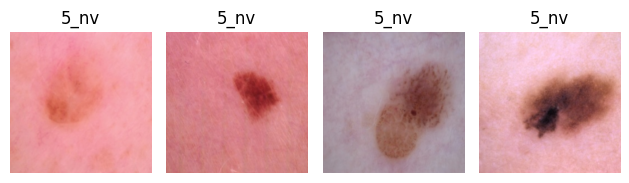

In [ ]:
# X, Y = train_datagen[0]
# print(X.shape, Y.shape)

# for i in range(4):
#   plt.subplot(1, 4, i+1)
#   plt.imshow((X[i]*255).astype(np.uint8))
#   plt.axis('off')
#   class_id = Y[i].argmax()
#   plt.title(str(class_id)+'_'+configs.CLASS_NAMES[class_id])
# plt.tight_layout()
# plt.show()

# Classifer 256 x 256

In [ ]:
classifier = tf.keras.models.load_model(configs.CLASSIFIER256_CHECKPOINT)
classifier.summary()

Model: "classifier256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
 softmax (Softmax)           (None, 7)                 0         
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


# Extraction

In [ ]:
extractor = tf.keras.models.Model(
                inputs=classifier.get_layer('resnet50').inputs,
                outputs=classifier.get_layer('resnet50').outputs)
extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# Running

In [22]:
import os

def run_extracting(extractor, datagen, subset):
    for X, filenames in datagen:
      features = extractor.predict(X, verbose=0)
      for i in range(len(filenames)):
          save_filename = 'outputs/features/' + filenames[i] \
                          .replace(subset, subset+'-feature-classifier256') \
                          .replace('.jpg', '.feat.npy')
          pardir = os.path.dirname(save_filename)
          if not os.path.exists(pardir):
              os.makedirs(pardir)

          np.save(save_filename, features[i])
          print(save_filename)
          # break
      # break

In [23]:
run_extracting(extractor, train_datagen, 'train')
run_extracting(extractor, val_datagen, 'val')
run_extracting(extractor, test_datagen, 'test')

Streaming output truncated to the last 5000 lines.
outputs/features/val-feature-classifier256/nv/ISIC_0031109.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0029461.feat.npy
outputs/features/val-feature-classifier256/bkl/ISIC_0031522.feat.npy
outputs/features/val-feature-classifier256/bkl/ISIC_0025033.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0027123.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0027213.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0031091.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0027749.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0033984.feat.npy
outputs/features/val-feature-classifier256/mel/ISIC_0029017.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0029848.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0028383.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0033976.feat.npy
outputs/features/val-feature-classifier256/nv/ISIC_0030713.fea